# Imports

In [1]:
import pandas as pd
import numpy as np
import inflect
import re
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from nltk.tokenize import word_tokenize,sent_tokenize
import gensim.downloader as api
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
import contractions
import unidecode
import demoji
from sklearn.preprocessing import LabelBinarizer
from emot.emo_unicode import UNICODE_EMOJI, UNICODE_EMOJI_ALIAS, EMOTICONS_EMO
from flashtext import KeywordProcessor
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential,Model
from keras.layers import Dense,Bidirectional,LSTM,Embedding, GlobalMaxPooling1D, GlobalMaxPooling3D
from tensorflow.keras.layers import Dropout
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping, ModelCheckpoint
import tweepy
from pandas import Series,DataFrame
import pandas as pd
import pickle

# Data Import and Visualization

In [16]:
df = pd.read_csv('https://query.data.world/s/5xzuftmozqteqbqzopbcgxbjzusyi7')

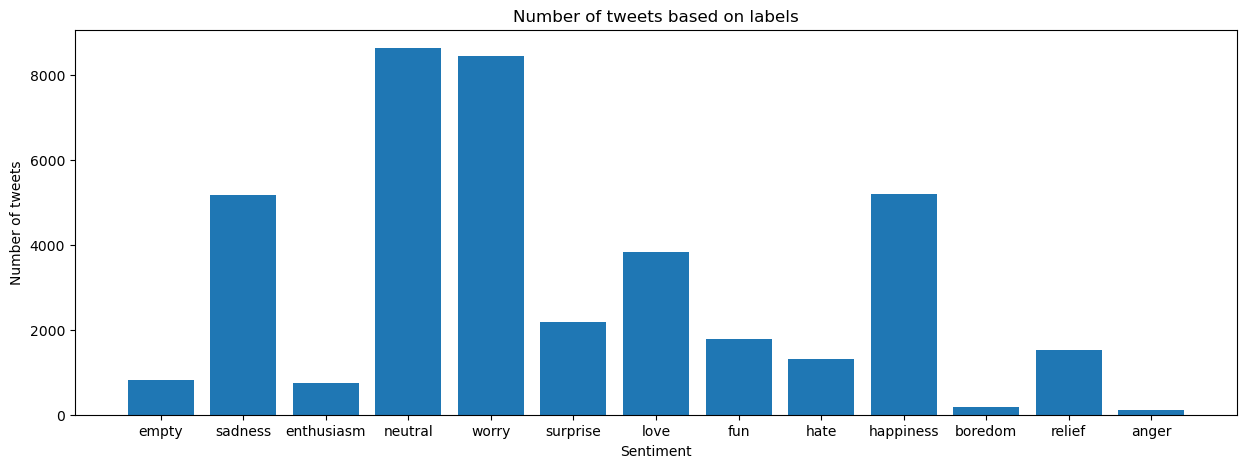

In [17]:
labels = df['sentiment']
data_vis ={}
for label in labels:
    data_vis[label] = data_vis.get(label, 0) + 1
fig = plt.figure(figsize = (15, 5))
sentiments = list(data_vis.keys())
values = list(data_vis.values())
# creating the bar plot
plt.bar(sentiments, values)
plt.xlabel("Sentiment")
plt.ylabel("Number of tweets")
plt.title("Number of tweets based on labels")
plt.show()

# Removing the unwanted labels and encoding the remaining labels

In [18]:
#converting our  above emotions to the labels and dropping the content
#df['sentiment'] = df['sentiment'].replace(labels)
#df['content']= list(map(lambda x: x.lower(), df['processed']))
df.drop(index=df[df['sentiment'] == 'love'].index, inplace=True)
df.drop(index=df[df['sentiment'] == 'surprise'].index, inplace=True)
df.drop(index=df[df['sentiment'] == 'relief'].index, inplace=True)
df.drop(index=df[df['sentiment'] == 'boredom'].index, inplace=True)
df.drop(index=df[df['sentiment'] == 'worry'].index, inplace=True)
df.drop(index=df[df['sentiment'] == 'anger'].index, inplace=True)
df.drop(index=df[df['sentiment'] == 'hate'].index, inplace=True)
df.drop(index=df[df['sentiment'] == 'empty'].index, inplace=True)
df.drop(index=df[df['sentiment'] == 'enthusiasm'].index, inplace=True)
df.drop(index=df[df['sentiment'] == 'fun'].index, inplace=True)
#df.drop(index=df[df['sentiment'] == 'neutral'].index, inplace=True)
encoder = LabelBinarizer()
encoder.fit(df.sentiment.unique())
with open("encoder", "wb") as file:
    pickle.dump(encoder, file)

# Preprocessing the data

In [19]:
#reomve pattern function, input_text is the text we want to process, the pattern is the pattern we want to remove
def remove_pattern(input_text, pattern):
    r = re.findall(pattern, input_text)
    for i in r:
        input_text = re.sub(i, '', input_text)
    return input_text

In [20]:
all_emoji_emoticons = {**EMOTICONS_EMO,**UNICODE_EMOJI_ALIAS, **UNICODE_EMOJI_ALIAS}
all_emoji_emoticons = {k:v.replace(":","").replace("_"," ").strip() for k,v in all_emoji_emoticons.items()}
kp_all_emoji_emoticons = KeywordProcessor()
for k,v in all_emoji_emoticons.items():
    kp_all_emoji_emoticons.add_keyword(k, v)

In [21]:
#preprocess the data
replacers = {'dm': 'direct message',
 'thx': 'thanks',
 'dming': 'direct messaging',
 'dmed': 'direct messaged',
 'plz': 'please',
 'u': 'you',
 'asap': 'as soon as possible',
 '...': '',
 '. . .': '',
 'r': 'are', 
 'tho': 'though', 'wassup' : 'whats up', 'lol': 'laughing out loud', 'layin': 'laying', 'y' :'why', 'bd' : 'birthday',
  'btw': 'by the way', 'ty': 'thank you', 'brb': 'be right back', 'omg': 'oh my god', 'yup' : 'yes', 'yep' : 'yes'}
def preprocess(df):
    #remove the @
    df['processed'] = np.vectorize(remove_pattern)(df['content'], "@[\w]*")
    
    #convert to lower case
    df.loc[:, 'processed'] = df.loc[:, 'processed'].str.lower()
    
    #converting don't -> do not
    removed = []
    for text in df['processed']:
        txt =[]
        for word in text.split():
            txt.append(contractions.fix(word))
        ex_txt = ' '.join(txt)
        removed.append(ex_txt)
    df.drop('processed', axis = 1, inplace = True)
    df['processed'] = removed
    
    #remove any links
    df['processed'] = df['processed'].str.replace('http[^\s]*',"")
    
    #convert emoji to text
    pr = []
    for text in df['processed']:
        pr.append(kp_all_emoji_emoticons.replace_keywords(text))
    df.drop('processed', axis = 1, inplace = True)
    df['processed'] = pr
    
    #remove the #
    df['processed'] = np.vectorize(remove_pattern)(df['processed'], "#")
    
    # converting unicode to ascii
    stemmer = PorterStemmer()
    removed = []
    for text in df['processed']:
        removed.append(unidecode.unidecode(text))
    df.drop('processed', axis = 1, inplace = True)
    df['processed'] = removed
    
    #remove the special characters, numbers, punctuations
    df['processed'] = df['processed'].str.replace("[^a-zA-Z#]", " ",regex=True)
    
    #converting common acronyms to common words
    df['processed'] = df['processed'] .str.replace('[...…]','').str.split().apply(lambda x: ' '.join([replacers.get(e, e) for e in x]))
    
     #remove the words smaller than 2
    #df['processed'] = df['processed'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
    
    #remove white spaces
    df['processed'] = df['processed'].str.strip()
    
    return df

In [22]:
df_x = df
df_y = df['sentiment']
df_x

,tweet_id,sentiment,author,content
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...
4,1956968416,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...
6,1956968487,sadness,ShansBee,"I should be sleep, but im not! thinking about ..."
8,1956969035,sadness,nic0lepaula,@charviray Charlene my love. I miss you
...,...,...,...,...
39992,1753918881,neutral,_Alectrona_,@jasimmo Ooo showing of your French skills!! l...
39993,1753918892,neutral,bushidosan,"@sendsome2me haha, yeah. Twitter has many uses..."
39994,1753918900,happiness,courtside101,Succesfully following Tayla!!
39995,1753918954,neutral,showMe_Heaven,@JohnLloydTaylor


In [23]:
x_train, x_rem, y_train, y_rem = train_test_split(df_x, df_y, test_size=0.5)
x_test_t, x_valid_t, y_test, y_valid = train_test_split(x_rem, y_rem, test_size=0.5)
df_processed_x = preprocess(x_train)
#convert the labels into categroical data using the keras library
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)
y_valid = encoder.transform(y_valid)
#The output of the y_train and y_test will be a binary matrix and has columns equal to the number of categories in the data.
df_processed_x
y_train

C:\Users\mangu\AppData\Local\Temp\ipykernel_12308\1721477037.py:33: FutureWarning: The default value of regex will change from True to False in a future version.
  df['processed'] = df['processed'].str.replace('http[^\s]*',"")
C:\Users\mangu\AppData\Local\Temp\ipykernel_12308\1721477037.py:57: FutureWarning: The default value of regex will change from True to False in a future version.
  df['processed'] = df['processed'] .str.replace('[...…]','').str.split().apply(lambda x: ' '.join([replacers.get(e, e) for e in x]))


array([[1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       ...,
       [0, 0, 1],
       [0, 1, 0],
       [0, 1, 0]])

In [24]:
df_processed_x
x_train = df_processed_x['processed']
x_test = x_test_t['content']
x_valid = x_valid_t['content']

In [25]:
df_processed_x['processed'].iloc[[190]]

24846    hey there it is a glorious morning monday s an...
Name: processed, dtype: object

In [26]:
x_train.shape

(9506,)

In [27]:
x_test.shape

(4753,)

In [28]:
x_valid.shape

(4753,)

In [29]:
x_train

27255    i am sooo jealous in a good way of course lc i...
35347    car just drove past my house blasting celine d...
19254                                    doin homework ugh
3662                             cannot believe er is over
10365    fantastic week in london but atrocious hour jo...
                               ...                        
17661                             phones about to die ttfn
21525    i forget are you in edinburgh check out edinbu...
17657                               fucking hates goodbyes
16894    malibu make me sleepy and he does not want to ...
36757             takes out a bill you can keep the change
Name: processed, Length: 9506, dtype: object

# Tokenizing the data and padding the text

In [30]:
tokenizer = Tokenizer(5000,lower=True)
combi = pd.concat([x_train, x_test], axis = 0)
tokenizer.fit_on_texts(combi)
#Since the BiLSTM model only considers numeric values, we convert our vector of tokens to numeric sequnces, that is each
#token is represented by its frequency in the text
x_seq = tokenizer.texts_to_sequences(x_train)
X_train = pad_sequences(x_seq, maxlen = 34, padding='post')
y_seq = tokenizer.texts_to_sequences(x_test)
X_test = pad_sequences(y_seq, maxlen = 34, padding='post')
z_seq = tokenizer.texts_to_sequences(x_valid)
X_valid = pad_sequences(z_seq, maxlen = 34, padding='post')
word_index = tokenizer.word_index

# Creating Word Embeddings

In [31]:
# Glove vector contains a 50 dimensional vector corresponding to each word in dictionary.
vocab = 'glove.6B.50d.txt'
# embeddings_index is a dictionary which contains the mapping of
# word with its corresponding 50d vector.
embeddings_index = {}
with open(vocab, encoding='utf8') as f:
    for line in f:
        # splitting each line of the glove.6B.50d in a list of items- in which
        # the first element is the word to be embedded, and from second
        # to the end of line contains the 50d vector.
        values = line.rstrip().rsplit(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

In [32]:
embedding_matrix = np.zeros((len(word_index)+1, 50))
for word, index in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
    else:
        embedding_matrix[index] = np.zeros(50)

# Building the Baseline Model and Predicting the results

In [33]:
#EarlyStopping and ModelCheckpoint
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)
mc = ModelCheckpoint('./model.h5', monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True)

In [34]:
def baseline_model(X,Y, classes):
    model=Sequential()
    model.add(Embedding(input_dim=len(word_index)+1, output_dim=50, input_length=len(X[0]), weights = [embedding_matrix], trainable=False))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(classes, activation = 'softmax'))
    model.add(GlobalMaxPooling1D())
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    ep = model.fit(X, Y, batch_size=64, epochs=10, verbose = 1, validation_data=(X_valid, y_valid))
    return model, ep

In [35]:
#Building the baseline model with only 3 labels
baselineModel, base_his = baseline_model(X_train,y_train, 3)

Epoch 1/10
149/149 [==============================] - 4s 12ms/step - loss: 1.0104 - accuracy: 0.5038 - val_loss: 0.9545 - val_accuracy: 0.5382
Epoch 2/10
149/149 [==============================] - 1s 9ms/step - loss: 0.9204 - accuracy: 0.5696 - val_loss: 0.9283 - val_accuracy: 0.5500
Epoch 3/10
149/149 [==============================] - 1s 9ms/step - loss: 0.8960 - accuracy: 0.5927 - val_loss: 0.9193 - val_accuracy: 0.5746
Epoch 4/10
149/149 [==============================] - 1s 9ms/step - loss: 0.8873 - accuracy: 0.6066 - val_loss: 0.9377 - val_accuracy: 0.5841
Epoch 5/10
149/149 [==============================] - 1s 9ms/step - loss: 0.8772 - accuracy: 0.6076 - val_loss: 0.9168 - val_accuracy: 0.5996
Epoch 6/10
149/149 [==============================] - 1s 9ms/step - loss: 0.8702 - accuracy: 0.6177 - val_loss: 0.9107 - val_accuracy: 0.6028
Epoch 7/10
149/149 [==============================] - 1s 9ms/step - loss: 0.8641 - accuracy: 0.6193 - val_loss: 0.9309 - val_accuracy: 0.6011
Epoch

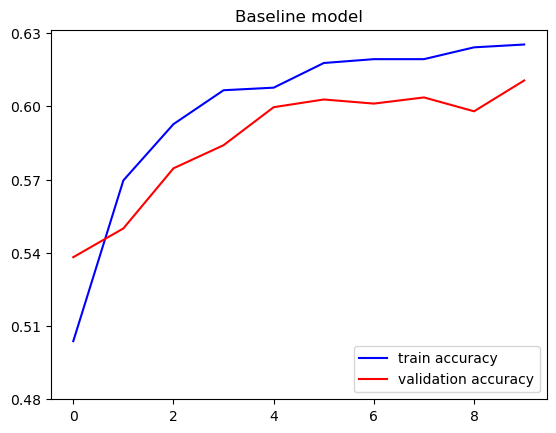

In [36]:
#Predicting with only 3 labels - Baseline Model
plt.plot(base_his.history['accuracy'],c='b',label='train accuracy')
plt.plot(base_his.history['val_accuracy'],c='r',label='validation accuracy')
plt.title("Baseline model")
plt.yticks(np.arange(0.48, 0.65, 0.03))
plt.legend(loc='lower right')
plt.show()

In [37]:
#Results with only 3 labels - Baseline Model
y_pred = np.argmax(baselineModel.predict(X_test), axis  =  1)
y_true = np.argmax(y_test, axis = 1)
from sklearn import metrics
print(metrics.classification_report(y_pred, y_true))

149/149 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.60      0.58      0.59      1369
           1       0.72      0.62      0.67      2502
           2       0.47      0.68      0.56       882

    accuracy                           0.62      4753
   macro avg       0.60      0.63      0.60      4753
weighted avg       0.64      0.62      0.62      4753



# Building the BiLSTM Model and Predicting the results

In [38]:
def build_model(X,Y, classes):
    #Dimension of our embeddings
    embedding_dim = 50
    model=Sequential()
    model.add(Embedding(input_dim=len(word_index)+1, output_dim=50, input_length=len(X[0]), weights = [embedding_matrix], trainable=False))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(256, return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(128)))
    model.add(Dense(classes, activation = 'softmax'))
    adam = keras.optimizers.Adam(learning_rate = 0.0001)
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
    ep = model.fit(X, Y, batch_size=128, epochs=25, verbose = 1, validation_data=(X_valid, y_valid), callbacks= [es, mc])
    return model, ep

In [39]:
#Building model with only 3 labels
bilstmModel, his=build_model(X_train,y_train, 3)

Epoch 1/25
75/75 [==============================] - ETA: 0s - loss: 1.0524 - accuracy: 0.4676
Epoch 1: val_accuracy improved from -inf to 0.47402, saving model to .\model.h5
75/75 [==============================] - 113s 1s/step - loss: 1.0524 - accuracy: 0.4676 - val_loss: 1.0331 - val_accuracy: 0.4740
Epoch 2/25
75/75 [==============================] - ETA: 0s - loss: 0.9906 - accuracy: 0.5108
Epoch 2: val_accuracy improved from 0.47402 to 0.50537, saving model to .\model.h5
75/75 [==============================] - 105s 1s/step - loss: 0.9906 - accuracy: 0.5108 - val_loss: 0.9943 - val_accuracy: 0.5054
Epoch 3/25
75/75 [==============================] - ETA: 0s - loss: 0.9595 - accuracy: 0.5379
Epoch 3: val_accuracy improved from 0.50537 to 0.53251, saving model to .\model.h5
75/75 [==============================] - 106s 1s/step - loss: 0.9595 - accuracy: 0.5379 - val_loss: 0.9621 - val_accuracy: 0.5325
Epoch 4/25
75/75 [==============================] - ETA: 0s - loss: 0.9465 - accur

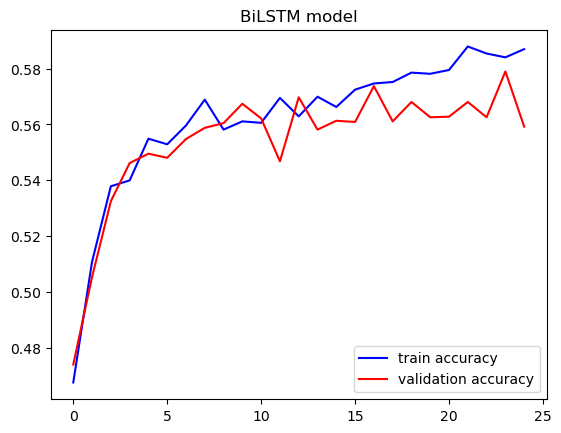

In [40]:
#Predicting with only 3 labels - bilstm model
plt.plot(his.history['accuracy'],c='b',label='train accuracy')
plt.plot(his.history['val_accuracy'],c='r',label='validation accuracy')
plt.title("BiLSTM model")
plt.legend(loc='lower right')
plt.show()

In [41]:
#Results with only 3 labels - bilstm model
y_pred =   np.argmax(bilstmModel.predict(X_test), axis  =  1)
y_true = np.argmax(y_test, axis = 1)
from sklearn import metrics
print(metrics.classification_report(y_pred, y_true))

149/149 [==============================] - 28s 173ms/step
              precision    recall  f1-score   support

           0       0.52      0.55      0.54      1239
           1       0.79      0.58      0.67      2922
           2       0.32      0.68      0.43       592

    accuracy                           0.59      4753
   macro avg       0.54      0.61      0.55      4753
weighted avg       0.66      0.59      0.60      4753



# Extracting the tweets

In [42]:
#Put your Bearer Token in the parenthesis below
client = tweepy.Client(bearer_token='AAAAAAAAAAAAAAAAAAAAAHiaigEAAAAA1hzpI79DUjAi9q8PvGD7lfTzWjQ%3Dw9PNTdJGBWQOWxJjY9l5yP1Z7fglAF5SQGbLN6LrzUHQ5Gvbkd')

# Get tweets that contain the hashtag #petday
# -is:retweet means I don't want retweets
# lang:en is asking for the tweets to be in english
query = 'covid -is:retweet'
tweets = client.search_recent_tweets(query = query, tweet_fields=['context_annotations', 'created_at'], max_results=100)

tweet_lst = [tweet.text for tweet in tweets.data]



data = {'content': tweet_lst}
tweet_df = DataFrame(data)
tweet_pro = preprocess(tweet_df)
tweet_pro

C:\Users\mangu\AppData\Local\Temp\ipykernel_12308\1721477037.py:33: FutureWarning: The default value of regex will change from True to False in a future version.
  df['processed'] = df['processed'].str.replace('http[^\s]*',"")
C:\Users\mangu\AppData\Local\Temp\ipykernel_12308\1721477037.py:57: FutureWarning: The default value of regex will change from True to False in a future version.
  df['processed'] = df['processed'] .str.replace('[...…]','').str.split().apply(lambda x: ' '.join([replacers.get(e, e) for e in x]))


,content,processed
0,https://t.co/c6oYJics9I,
1,@ZaleskiLuke @DonaldJTrumpJr The fake reality ...,the fake reality of the lies of the last years...
2,National Guard Gave COVID-19 Vaccine Instead o...,national guard gave covid vaccine instead of f...
3,（３）\nスイス、アメリカ、チリ、イングランドの、＃ワクチン接種 と #死亡率 の関係\nh...,suisu amerika chiri ingurandono #wakuchinJie Z...
4,When Trump tweeted covfefe he was trying to wa...,when trump tweeted covfefe he was trying to wa...
...,...,...
95,@mustafadambasa1 Maalesef bu fotoğraftan saatl...,maalesef bu fotograftan saatler sonra selvi ha...
96,@OVVeterans @nathaliejacoby1 Please explain? I...,please explain i presume this is loaded toward...
97,"@ZDFheute Was soll denn das sein ""Long Covid n...",was soll denn das sein long covid nach impfung...
98,@AlisonGraham58 @KensingtonRoyal @EarthshotPri...,wk fans said recipients no invited due to covi...


In [43]:
x_dat = tweet_pro['processed']
x_dat

0                                                      
1     the fake reality of the lies of the last years...
2     national guard gave covid vaccine instead of f...
3     suisu amerika chiri ingurandono #wakuchinJie Z...
4     when trump tweeted covfefe he was trying to wa...
                            ...                        
95    maalesef bu fotograftan saatler sonra selvi ha...
96    please explain i presume this is loaded toward...
97    was soll denn das sein long covid nach impfung...
98    wk fans said recipients no invited due to covi...
99    country music radio internet country radio liv...
Name: processed, Length: 100, dtype: object

# Predicting the emotion from tweets

In [44]:
x_seq = tokenizer.texts_to_sequences(x_dat)
x_data = pad_sequences(x_seq, maxlen = 34, padding='post')
y_pred = bilstmModel.predict(x_data)

4/4 [==============================] - 2s 336ms/step


In [45]:
#Building model with only 3 labels
with open('encoder', 'rb') as file:
    encoder = pickle.load(file)
for index, value in enumerate(np.sum(y_pred, axis=0) / len(y_pred)):
    print(encoder.classes_[index] + ": " + str(value))

happiness: 0.17110315
neutral: 0.6252595
sadness: 0.20363742


# Extracting the tweets - Happy

In [47]:
#Put your Bearer Token in the parenthesis below
client = tweepy.Client(bearer_token='AAAAAAAAAAAAAAAAAAAAAHiaigEAAAAA1hzpI79DUjAi9q8PvGD7lfTzWjQ%3Dw9PNTdJGBWQOWxJjY9l5yP1Z7fglAF5SQGbLN6LrzUHQ5Gvbkd')

# Get tweets that contain the hashtag #petday
# -is:retweet means I don't want retweets
# lang:en is asking for the tweets to be in english
query = 'happy -is:retweet'
tweets = client.search_recent_tweets(query = query, tweet_fields=['context_annotations', 'created_at'], max_results=100)

tweet_lst = [tweet.text for tweet in tweets.data]



data = {'content': tweet_lst}
tweet_df = DataFrame(data)
tweet_pro = preprocess(tweet_df)
tweet_pro

C:\Users\mangu\AppData\Local\Temp\ipykernel_12308\1721477037.py:33: FutureWarning: The default value of regex will change from True to False in a future version.
  df['processed'] = df['processed'].str.replace('http[^\s]*',"")
C:\Users\mangu\AppData\Local\Temp\ipykernel_12308\1721477037.py:57: FutureWarning: The default value of regex will change from True to False in a future version.
  df['processed'] = df['processed'] .str.replace('[...…]','').str.split().apply(lambda x: ' '.join([replacers.get(e, e) for e in x]))


,content,processed
0,"@NFLonCBS Hope your happy bronco land, this is...",hope your happy bronco land this is exactly th...
1,So happy for our boys getting the W in London....,so happy for our boys getting the w in london ...
2,I don’t share a lot of stuff anymore bc I genu...,i do not share a lot of stuff anymore because ...
3,Happy birthday to that friend I had in middle ...,happy birthday to that friend i had in middle ...
4,@tomomi_rea Good morning my wonderful Love Tom...,good morning my wonderful love tomomi kissing ...
...,...,...
91,Fans wish Ryan Reynolds a happy birthday 🎉 \n#...,fans wish ryan reynolds a happy birthday tada ...
92,"@trenomortgage Good afternoon, I apologize for...",good afternoon i apologize for the chat and se...
93,Fans wish Ryan Reynolds a happy birthday 🎉 \n#...,fans wish ryan reynolds a happy birthday tada ...
94,@klayman87 @m1nd1 @courtneyrsexton Aw I someho...,aw i somehow missed that it was mindi s birthd...


In [48]:
x_dat = tweet_pro['processed']
x_dat

0     hope your happy bronco land this is exactly th...
1     so happy for our boys getting the w in london ...
2     i do not share a lot of stuff anymore because ...
3     happy birthday to that friend i had in middle ...
4     good morning my wonderful love tomomi kissing ...
                            ...                        
91    fans wish ryan reynolds a happy birthday tada ...
92    good afternoon i apologize for the chat and se...
93    fans wish ryan reynolds a happy birthday tada ...
94    aw i somehow missed that it was mindi s birthd...
95    yes heart they do wonderful things in the atla...
Name: processed, Length: 96, dtype: object

In [49]:
x_seq = tokenizer.texts_to_sequences(x_dat)
x_data = pad_sequences(x_seq, maxlen = 34, padding='post')
y_pred = bilstmModel.predict(x_data)

3/3 [==============================] - 2s 458ms/step


In [50]:
#Building model with only 3 labels
with open('encoder', 'rb') as file:
    encoder = pickle.load(file)
for index, value in enumerate(np.sum(y_pred, axis=0) / len(y_pred)):
    print(encoder.classes_[index] + ": " + str(value))

happiness: 0.50294125
neutral: 0.3275609
sadness: 0.1694978


#  Extracting the tweets - Sad

In [51]:
#Put your Bearer Token in the parenthesis below
client = tweepy.Client(bearer_token='AAAAAAAAAAAAAAAAAAAAAHiaigEAAAAA1hzpI79DUjAi9q8PvGD7lfTzWjQ%3Dw9PNTdJGBWQOWxJjY9l5yP1Z7fglAF5SQGbLN6LrzUHQ5Gvbkd')

# Get tweets that contain the hashtag #petday
# -is:retweet means I don't want retweets
# lang:en is asking for the tweets to be in english
query = 'sad -is:retweet'
tweets = client.search_recent_tweets(query = query, tweet_fields=['context_annotations', 'created_at'], max_results=100)

tweet_lst = [tweet.text for tweet in tweets.data]



data = {'content': tweet_lst}
tweet_df = DataFrame(data)
tweet_pro = preprocess(tweet_df)
tweet_pro

C:\Users\mangu\AppData\Local\Temp\ipykernel_12308\1721477037.py:33: FutureWarning: The default value of regex will change from True to False in a future version.
  df['processed'] = df['processed'].str.replace('http[^\s]*',"")
C:\Users\mangu\AppData\Local\Temp\ipykernel_12308\1721477037.py:57: FutureWarning: The default value of regex will change from True to False in a future version.
  df['processed'] = df['processed'] .str.replace('[...…]','').str.split().apply(lambda x: ' '.join([replacers.get(e, e) for e in x]))


,content,processed
0,@nepostizavam Joj sad vidim da možemo da dočar...,joj sad vidim da mozemo da docaramo hrakljusyo...
1,@ashoswai This is so sad wtf,this is so sad wtf
2,Thankful for the friends who checkup on me eve...,thankful for the friends who checkup on me eve...
3,Sad but true . https://t.co/ZUXpERH3y0,sad but true
4,@sad_mahalle #مهسا_امینی https://t.co/eJ2O4Sw7gi,mhs myny
...,...,...
92,@CGasparino @BillAckman @kevinolearytv Even if...,even if you are trolling really pathetic if yo...
93,@katerrinna91 i don’t mean seriously I love hi...,i do not mean seriously i love him with my who...
94,@tuba_ali321 Pri is maintaining distance and a...,pri is maintaining distance and according to l...
95,@writingnomad999 Very sad- been through it mys...,very sad been through it myself a few times do...


In [52]:
x_dat = tweet_pro['processed']
x_dat

0     joj sad vidim da mozemo da docaramo hrakljusyo...
1                                    this is so sad wtf
2     thankful for the friends who checkup on me eve...
3                                          sad but true
4                                              mhs myny
                            ...                        
92    even if you are trolling really pathetic if yo...
93    i do not mean seriously i love him with my who...
94    pri is maintaining distance and according to l...
95    very sad been through it myself a few times do...
96    never go out sad about a bitch thinking she go...
Name: processed, Length: 97, dtype: object

In [53]:
x_seq = tokenizer.texts_to_sequences(x_dat)
x_data = pad_sequences(x_seq, maxlen = 34, padding='post')
y_pred = bilstmModel.predict(x_data)

4/4 [==============================] - 2s 411ms/step


In [54]:
#Building model with only 3 labels
with open('encoder', 'rb') as file:
    encoder = pickle.load(file)
for index, value in enumerate(np.sum(y_pred, axis=0) / len(y_pred)):
    print(encoder.classes_[index] + ": " + str(value))

happiness: 0.20805721
neutral: 0.27702224
sadness: 0.5149206
